# Evolutionary Algorithm

In [2]:
import random

import matplotlib.pyplot as plt

In [60]:
class Individual:
    def __init__(self, string, fitness=0):
        self.string = string
        self.fitness = fitness

In [61]:
from difflib import SequenceMatcher


def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()


similar("foo", "bar"), similar("hello", "Hello"), similar("foo", "foo")

(0.0, 0.8, 1.0)

In [62]:
def spawn_population(length=26, size=100):
    population = []
    for i in range(size):
        string = "".join(random.choices(alphabet, k=length))
        individual = Individual(string)
        population.append(individual)
    return population

In [53]:
def recombine(p1, p2):
    i = random.randint(0, len(p1.string))
    child1 = p1.string[:i] + p2.string[i:]
    child2 = p2.string[:i] + p1.string[i:]
    return Individual(child1), Individual(child2)

In [54]:
def mutate(x, mut_rate=0.01):
    new_x = []
    for char in x.string:
        if random.random() < mut_rate:
            new_x.append(random.choice(alphabet))
        else:
            new_x.append(char)
    return Individual("".join(new_x))

In [55]:
def evaluate_population(population, target):
    avg_fit = 0
    for i in range(len(population)):
        fit = similar(population[i].string, target)
        population[i].fitness = fit
        avg_fit += fit
    return population, avg_fit / len(population)

In [56]:
def next_generation(population, size=100, length=26, mut_rate=0.01):
    new_population = []
    while len(new_population) < size:
        parents = random.choices(
            population, k=2, weights=[x.fitness for x in population]
        )
        offspring = recombine(*parents)
        offspring = [mutate(o, mut_rate=mut_rate) for o in offspring]
        new_population.extend(offspring)
    return new_population

In [125]:
alphabet = "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ,.! "
target = "Hello World!"

num_generations = 300
population_size = 1000
str_len = len(target)
mutation_rate = 0.0001

population_fit = []
population = spawn_population(size=population_size, length=str_len)

In [126]:
population, avg_fit = evaluate_population(population, target)
population.sort(key=lambda x: x.fitness, reverse=True)
avg_fit

0.11258333333333306

In [127]:
for p in population[:3]:
    print(p.string, p.fitness)

!eoMywIzlom! 0.3333333333333333
XeWLowffhulc 0.3333333333333333
LeWr!UhOy tm 0.3333333333333333


In [128]:
for gen in range(num_generations):
    population, avg_fit = evaluate_population(population, target)
    population_fit.append(avg_fit)
    population = next_generation(
        population, size=population_size, length=str_len, mut_rate=mutation_rate
    )

In [129]:
population, avg_fit = evaluate_population(population, target)
population.sort(key=lambda x: x.fitness, reverse=True)
avg_fit

0.913916666666655

In [130]:
for p in population[:3]:
    print(p.string, p.fitness)

Hello orldd! 0.9166666666666666
HelloWorldm! 0.9166666666666666
HelloWorld!! 0.9166666666666666


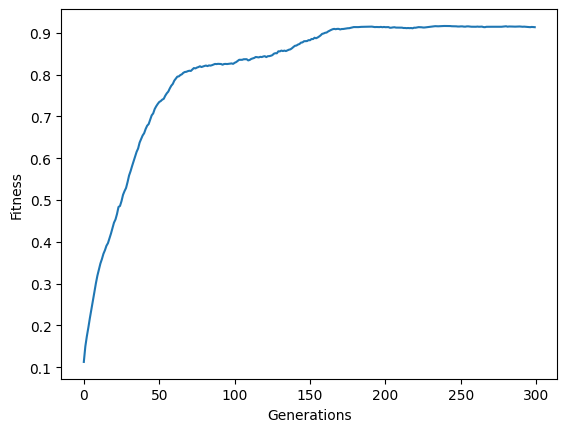

In [131]:
plt.plot(population_fit)
plt.xlabel("Generations")
plt.ylabel("Fitness");

## Genetic Algorithm for Cart Pole

In [186]:
import numpy as np
import torch
import torch.nn.functional as F
from tqdm.notebook import trange


def model(x, unpacked_params):
    l1, b1, l2, b2, l3, b3 = unpacked_params
    y = F.relu(F.linear(x, l1, b1))
    y = F.relu(F.linear(y, l2, b2))
    y = F.log_softmax(F.linear(y, l3, b3), dim=0)
    return y

In [137]:
def unpack_params(params, layers=[(25, 4), (10, 25), (2, 10)]):
    unpacked_params = []
    i = 0
    for out, inp in layers:
        s, e = i, i + inp * out
        weights = params[s:e].view((out, inp))
        s, e = e, e + out
        bias = params[s:e]
        i = e
        unpacked_params.extend([weights, bias])
    return unpacked_params

In [140]:
layers = [(25, 4), (10, 25), (2, 10)]
np.sum([(np.prod(layer) + layer[0]) for layer in layers])

407

In [144]:
total = 0
for l in unpack_params(torch.rand(407)):
    print(l.shape)
    total += np.prod(l.shape)
total

torch.Size([25, 4])
torch.Size([25])
torch.Size([10, 25])
torch.Size([10])
torch.Size([2, 10])
torch.Size([2])


407

In [145]:
def spawn_population(n=50, size=407):
    population = []
    for i in range(n):
        vec = torch.randn(size) / 2.0
        fit = 0
        p = {"params": vec, "fitness": fit}
        population.append(p)
    return population

In [180]:
def recombine(x1, x2):
    x1 = x1["params"]
    x2 = x2["params"]
    l = x1.shape[0]
    i = np.random.randint(l)
    child1 = torch.cat([x1[:i], x2[i:]])
    child2 = torch.cat([x2[:i], x1[i:]])
    c1 = {"params": child1, "fitness": 0.0}
    c2 = {"params": child2, "fitness": 0.0}
    return c1, c2

In [181]:
def mutate(x, rate=0.01):
    x_ = x["params"]
    num_to_change = int(rate * x_.shape[0])
    idx = np.random.randint(low=0, high=x_.shape[0], size=(num_to_change,))
    x_[idx] = torch.randn(num_to_change) / 10.0
    x["params"] = x_
    return x

In [182]:
import gymnasium as gym

env = gym.make("CartPole-v1")


def test_model(agent):
    observation, _info = env.reset()
    score = 0
    while True:
        state = torch.from_numpy(observation)
        params = unpack_params(agent["params"])
        probs = model(state, params)
        # action = torch.multinomial(probs, 1)
        action = torch.distributions.Categorical(probs=probs).sample()
        observation, _reward, done, trunc, _info = env.step(action.item())
        if done or trunc:
            break
        score += 1
    return score

In [183]:
def evaluate_population(population):
    total_fit = 0
    for agent in population:
        score = test_model(agent)
        agent["fitness"] = score
        total_fit += score
    return population, total_fit / len(population)

In [184]:
def next_generation(population, mut_rate=0.001, tournament_size=0.2):
    new_population = []
    while len(new_population) < len(population):
        rids = np.random.randint(
            low=0, high=len(population), size=(int(tournament_size * len(population)))
        )
        batch = np.array(
            [[i, x["fitness"]] for (i, x) in enumerate(population) if i in rids]
        )
        scores = batch[batch[:, 1].argsort()]
        i0, i1 = int(scores[-1][0]), int(scores[-2][0])
        parent0, parent1 = population[i0], population[i1]
        offspring = recombine(parent0, parent1)
        offspring = [mutate(off, rate=mut_rate) for off in offspring]
        new_population.extend(offspring)
    return new_population

In [187]:
num_generations = 25
population_size = 500
mutation_rate = 0.01
population_fit = []
population = spawn_population(n=population_size, size=407)
for i in trange(num_generations):
    population, avg_fit = evaluate_population(population)
    population_fit.append(avg_fit)
    population = next_generation(
        population, mut_rate=mutation_rate, tournament_size=0.2
    )

  0%|          | 0/25 [00:00<?, ?it/s]

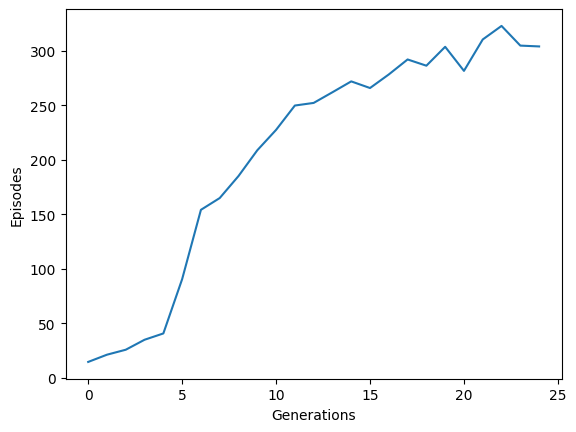

In [190]:
plt.plot(population_fit)
plt.xlabel("Generations")
plt.ylabel("Episodes");